In [1]:
import pandas as pd

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned' if (df[col] >= 0).all() else 'integer')

    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')

    return df

def readCSV(filepath, chunk_size=None):
    if chunk_size:
        chunks = []
        for chunk in pd.read_csv(filepath, chunksize=chunk_size, low_memory=False):
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        data = pd.concat(chunks, ignore_index=True)
        del chunks
    else:
        data = pd.read_csv(filepath, low_memory=False)
        data = optimize_memory(data)

    return data

# Load CSV file here
data = readCSV("GUIDE_Train.csv", chunk_size=50000)


In [2]:

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from joblib import dump


def preprocess_data(data, drop_target_na=True):
    print("\n ############## Data Info:#############")
    print(data.info())

    print("\n Data Description:")
    print(data.describe())

    print("\n Shape of Data:")
    print(data.shape)

    print("\n Column Names:")
    print(data.columns.tolist())

    print("\n First 5 Rows:")
    print(data.head())

    # Handling Missing Values   
    print("\n Missing Values Before Dropping Columns:")
    print(data.isnull().sum())

    # Dropping Columns from Train dataset which has larger null values except IncidentGrade column
    columns_to_drop = [
        'MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
        'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
        'SuspicionLevel', 'LastVerdict'
    ]
    data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    print("\n Dropped irrelevant columns.")

    print("\n Shape After Dropping Columns:")
    print(data.shape)

    print("\n Remaining Columns:")
    print(data.columns.tolist())

    print("\n Missing Values After Dropping Columns:")
    print(data.isnull().sum())

    # We cannot have missing values in 'IncidentGrade' column - This is target column. Dropping rows from 'IncidentGrade' column
    if drop_target_na and 'IncidentGrade' in data.columns:
        data = data.dropna(subset=['IncidentGrade'])
        print("\n Dropped rows where 'IncidentGrade' is missing.")

    print("\n Missing Values After Dropping 'IncidentGrade' NA:")
    print(data.isnull().sum())

    # Removing Duplicates
    print("\n Duplicate Rows:", data.duplicated().sum())
    data = data.drop_duplicates()
    print(f"\n Dropped duplicate rows. Number of rows now: {data.shape[0]}")

    print("\n Shape After Removing Duplicates:")
    print(data.shape)

    # Target variable distribution
    if 'IncidentGrade' in data.columns:
        print("\n Unique Values in 'IncidentGrade':")
        print(data['IncidentGrade'].unique())

        print("\n Target Variable Distribution:")
        print(data['IncidentGrade'].value_counts())

    # Feature Engineering
    if 'Timestamp' in data.columns:
        data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
        data['Year'] = data['Timestamp'].dt.year
        data['Month'] = data['Timestamp'].dt.month
        data['Day'] = data['Timestamp'].dt.day
        data['Hour'] = data['Timestamp'].dt.hour
        data.drop(columns='Timestamp', inplace=True)
        print("\n Extracted Year, Month, Day, Hour from 'Timestamp' and dropped it.")

    # ------------------ BEFORE ENCODING: Print Unique Value Counts ------------------
    print("\n--- Unique Value Counts in Important Categorical Columns ---\n")
    categorical_columns_to_check = ['IncidentGrade', 'EvidenceRole', 'EntityType', 'Category']
    for col in categorical_columns_to_check:
        if col in data.columns:
            print(f"{col} Counts:\n{data[col].value_counts()}\n")
    print("-" * 60)

    # Encoding
    print("\n Encoding Categorical Variables...")

    # Define columns
    categorical_cols = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']
    
    # Apply Label Encoding for 'IncidentGrade' and 'EvidenceRole'
    """Label Encoding for IncidentGrade and EvidenceRole.
       IncidentGrade → {BenignPositive: 0, TruePositive: 1, FalsePositive: 2} EvidenceRole → {Related: 0, Impacted: 1}"""
    
    label_enc = LabelEncoder()
    if 'IncidentGrade' in data.columns:
        data['IncidentGrade'] = label_enc.fit_transform(data['IncidentGrade'])
    if 'EvidenceRole' in data.columns:
        data['EvidenceRole'] = label_enc.fit_transform(data['EvidenceRole'])

    # Apply Target Encoding for 'Category' and 'EntityType'
    # For EntityType and Category, using Target Encoding to replace each category with the mean target value.
    target_enc = TargetEncoder()
    if 'EntityType' in data.columns and 'IncidentGrade' in data.columns:
        data['EntityType'] = target_enc.fit_transform(data['EntityType'], data['IncidentGrade'])
    if 'Category' in data.columns and 'IncidentGrade' in data.columns:
        data['Category'] = target_enc.fit_transform(data['Category'], data['IncidentGrade'])

    # Apply One-Hot Encoding for remaining categorical variables (if any)
    other_categoricals = data.select_dtypes(include=['object', 'category']).columns.tolist()
    if other_categoricals:
        data = pd.get_dummies(data, columns=other_categoricals, drop_first=True)
        print(f"\n Applied One-Hot Encoding to: {other_categoricals}")

    print("\n Final Shape of Data after Encoding:", data.shape)
    print("\n Final First 5 Rows after Encoding:")
    print(data.head())

    return data


# Assuming 'data' is available in the current scope from Part 1
train_data = preprocess_data(data, drop_target_na=True)

# Save the cleaned dataset
dump(train_data, 'cleaned_train_data.joblib')
print("\n Cleaned dataset saved to 'cleaned_train_data.joblib'")



 ############## Data Info:#############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9516837 entries, 0 to 9516836
Data columns (total 45 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  uint64  
 1   OrgId               uint16  
 2   IncidentId          uint32  
 3   AlertId             uint32  
 4   Timestamp           object  
 5   DetectorId          uint16  
 6   AlertTitle          uint32  
 7   Category            object  
 8   MitreTechniques     object  
 9   IncidentGrade       category
 10  ActionGrouped       object  
 11  ActionGranular      object  
 12  EntityType          object  
 13  EvidenceRole        category
 14  DeviceId            uint32  
 15  Sha256              uint32  
 16  IpAddress           uint32  
 17  Url                 uint32  
 18  AccountSid          uint32  
 19  AccountUpn          uint32  
 20  AccountObjectId     uint32  
 21  AccountName         uint32  
 22  DeviceName          uint3


 Loaded cleaned dataset from 'cleaned_train_data.joblib'


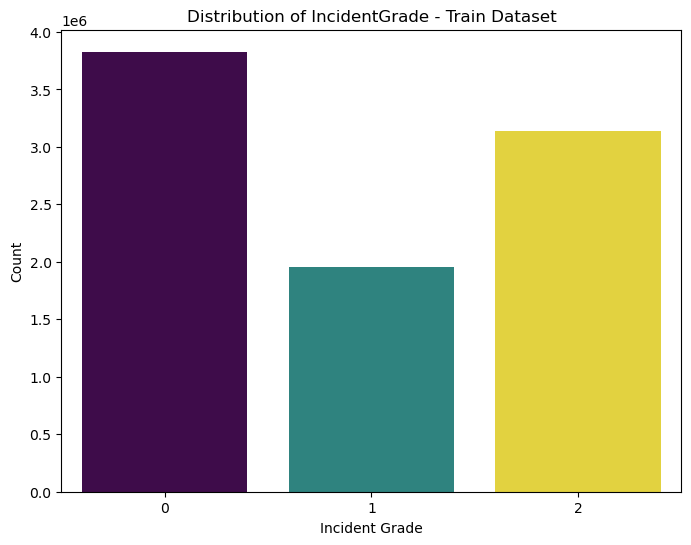

Target variable distribution:
IncidentGrade
0    3827800
2    3140126
1    1954879
Name: count, dtype: int64


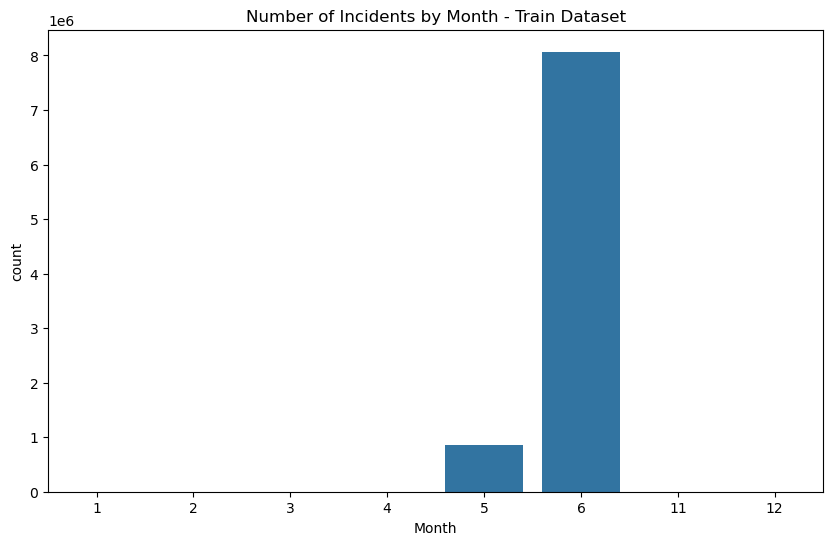

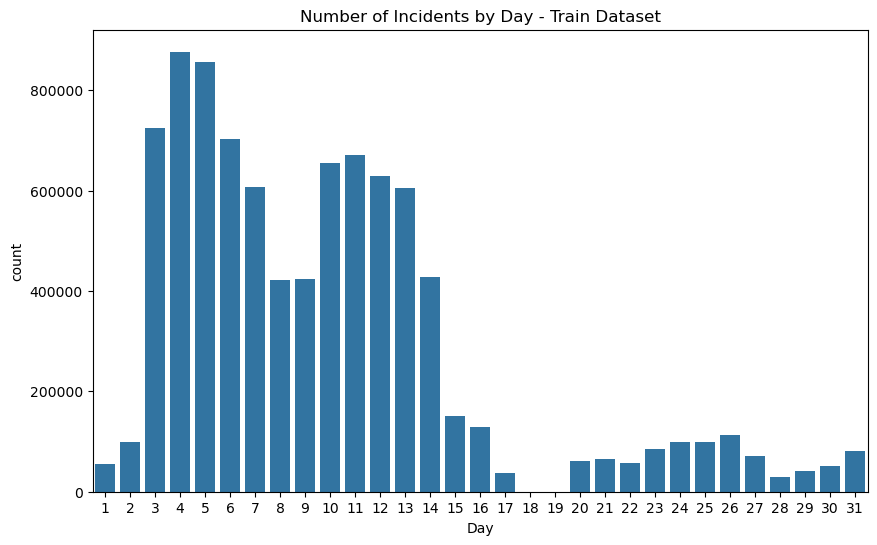

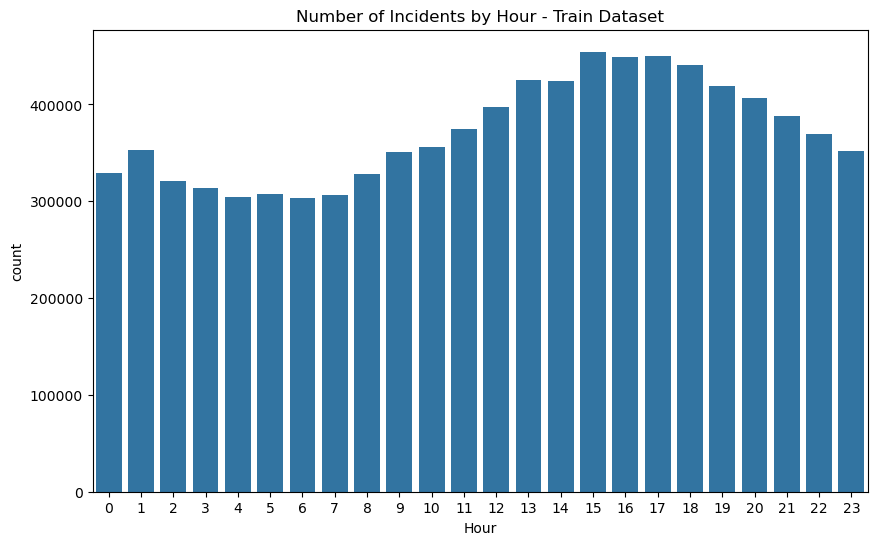

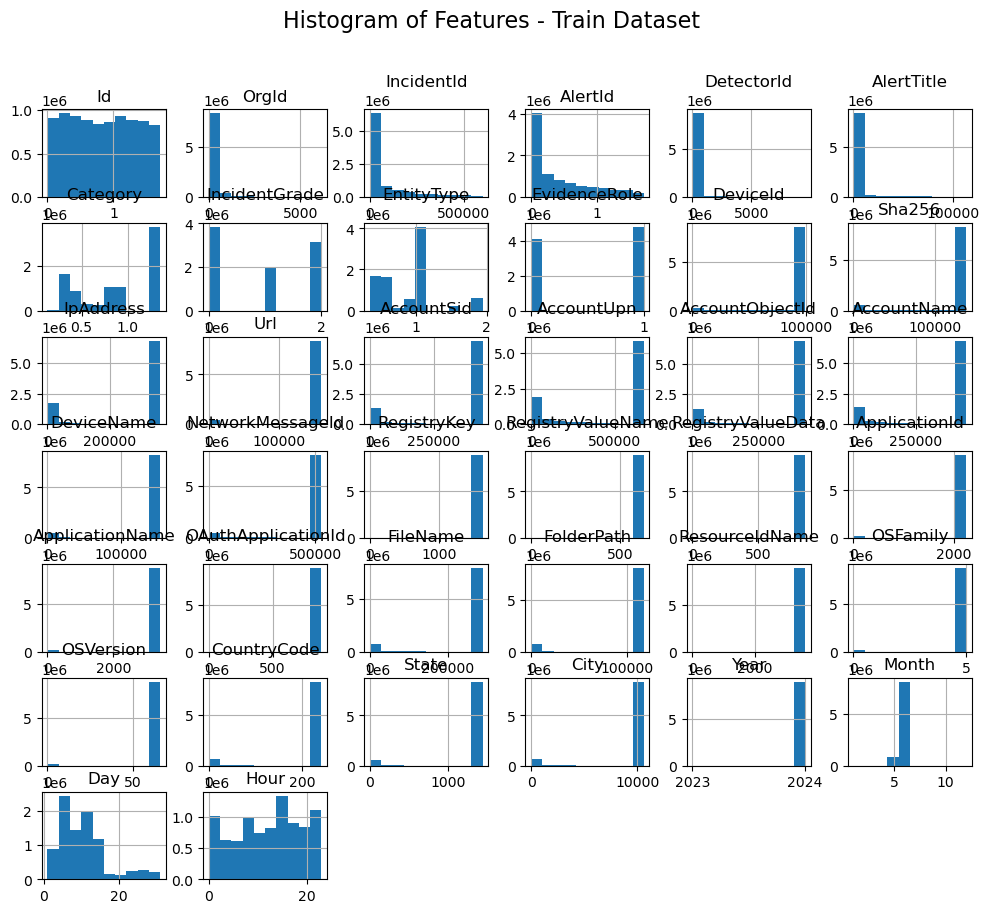


 Plotting Selected Columns Correlation Heatmap...


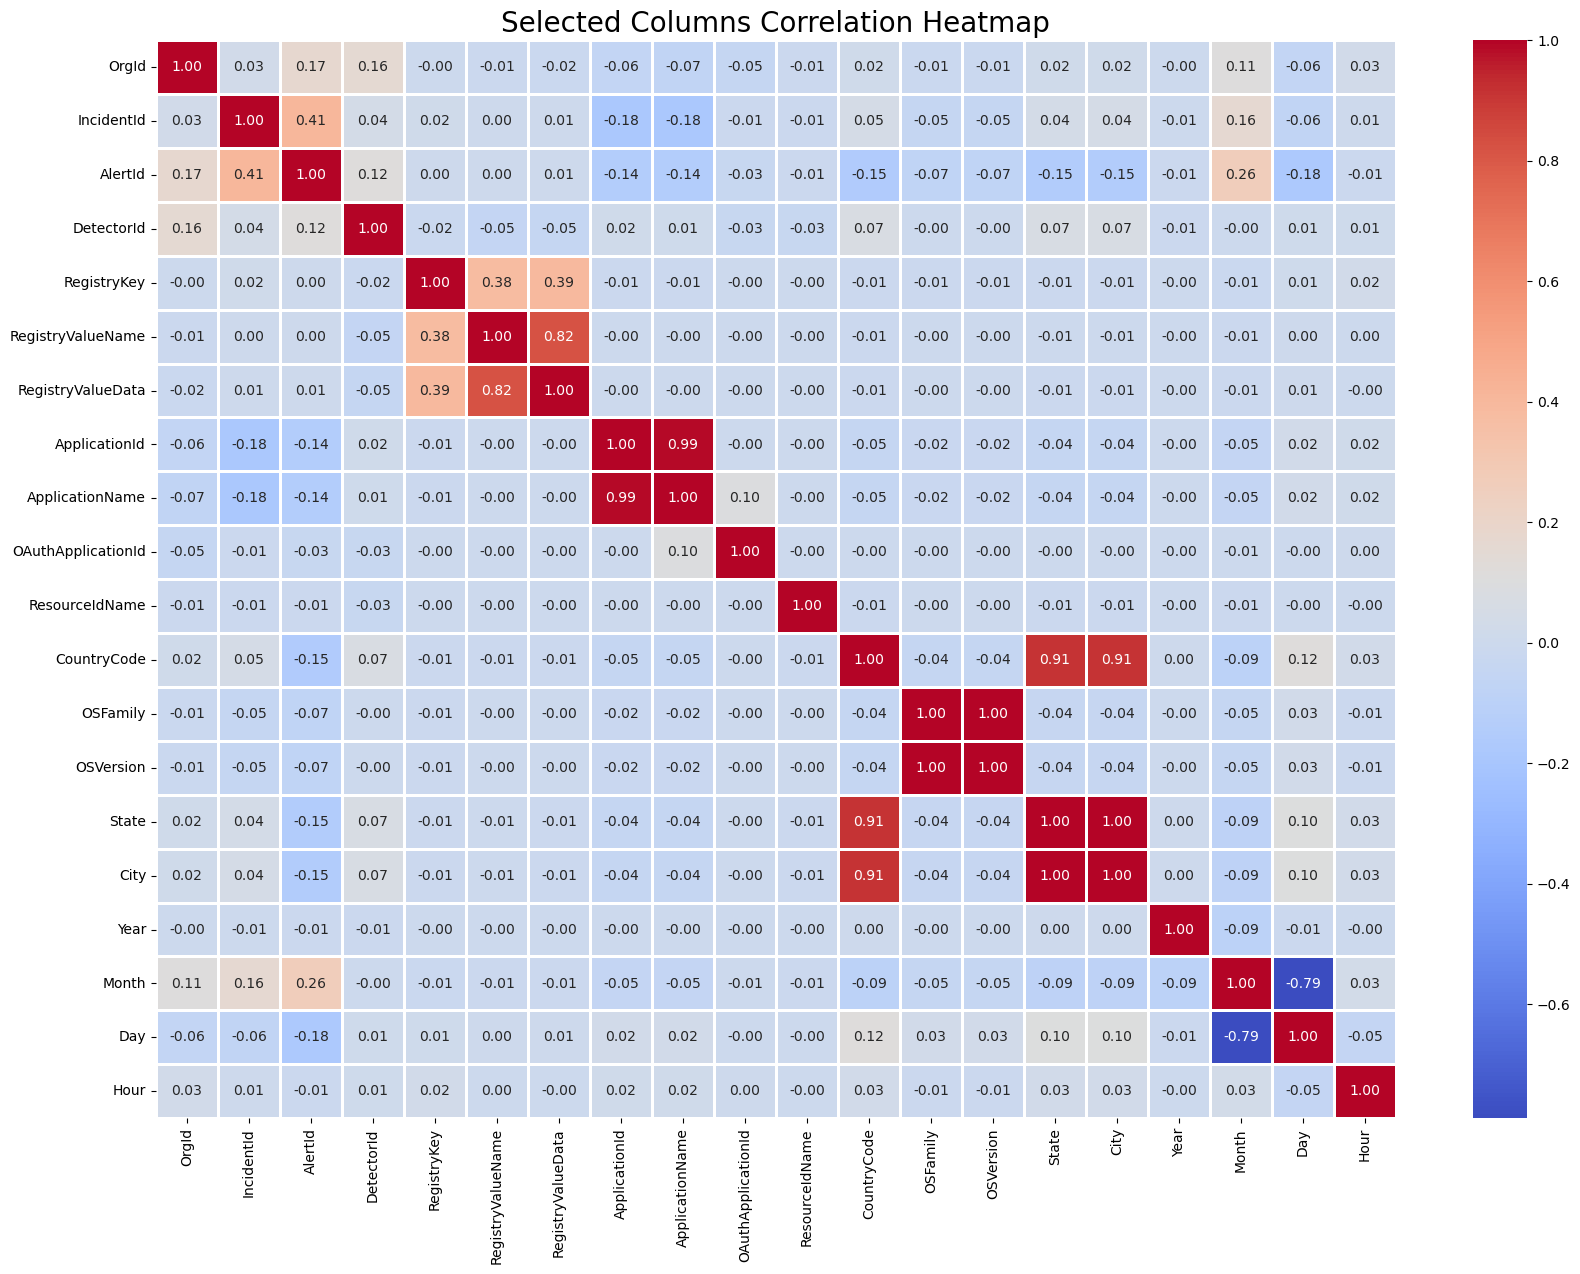

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

def explore_data(data, dataset_name="Dataset", plot_target_distribution=True):
    """
    Function to plot distributions and basic exploration of the dataset.
    
    Parameters:
    - data: DataFrame to explore
    - dataset_name: Name of the dataset (for titles)
    - plot_target_distribution: Whether to plot IncidentGrade distribution
    """
    # 1. Plot Target variable distribution
    if plot_target_distribution and 'IncidentGrade' in data.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x='IncidentGrade', hue='IncidentGrade', palette='viridis', legend=False)
        plt.title(f"Distribution of IncidentGrade - {dataset_name}")
        plt.xlabel("Incident Grade")
        plt.ylabel("Count")
        plt.show()
        
        print("Target variable distribution:")
        print(data['IncidentGrade'].value_counts())
    
    # 2. Incidents by Month
    if 'Month' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Month', data=data)
        plt.title(f'Number of Incidents by Month - {dataset_name}')
        plt.show()

    # 3. Incidents by Day
    if 'Day' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Day', data=data)
        plt.title(f'Number of Incidents by Day - {dataset_name}')
        plt.show()

    # 4. Incidents by Hour
    if 'Hour' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Hour', data=data)
        plt.title(f'Number of Incidents by Hour - {dataset_name}')
        plt.show()

    # 5. Histogram of all features
    data.hist(figsize=(12,10))
    plt.suptitle(f'Histogram of Features - {dataset_name}', fontsize=16)
    plt.show()

    # 6. Bar Plots for Categorical Features
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        plt.figure(figsize=(6, 4))
        data[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col} - {dataset_name}')
        plt.xlabel(col)
        plt.show()

    # 7. Specific Correlation Heatmap (Selected columns)
    print("\n Plotting Selected Columns Correlation Heatmap...")
    correlation_columns = [
        'OrgId','IncidentId','AlertId','DetectorId','RegistryKey', 
        'RegistryValueName', 'RegistryValueData','ApplicationId', 
        'ApplicationName','OAuthApplicationId','ResourceIdName', 
        'CountryCode','OSFamily','OSVersion','State','City',
        'Year','Month','Day','Hour'
    ]
    subset_df = data[correlation_columns].copy()

    plt.figure(figsize=(20, 14))
    subset_corr_matrix = subset_df.corr()
    sns.heatmap(subset_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.8)
    plt.title('Selected Columns Correlation Heatmap', fontsize=20)
    plt.show()



# Load cleaned data from joblib
train_data = load('cleaned_train_data.joblib')
print("\n Loaded cleaned dataset from 'cleaned_train_data.joblib'")

# Explore the loaded data
explore_data(train_data, dataset_name="Train Dataset")

In [4]:
import pandas as pd

def optimize_memory(df):
    for col in df.select_dtypes(include=['int64', 'float64']).columns:
        df[col] = pd.to_numeric(df[col], downcast='unsigned' if (df[col] >= 0).all() else 'integer')

    for col in df.select_dtypes(include=['object']).columns:
        num_unique_values = df[col].nunique()
        num_total_values = len(df[col])
        if num_unique_values / num_total_values < 0.5:
            df[col] = df[col].astype('category')

    return df

def readCSV(filepath, chunk_size=None):
    if chunk_size:
        chunks = []
        for chunk in pd.read_csv(filepath, chunksize=chunk_size, low_memory=False):
            chunk = optimize_memory(chunk)
            chunks.append(chunk)
        data = pd.concat(chunks, ignore_index=True)
        del chunks
    else:
        data = pd.read_csv(filepath, low_memory=False)
        data = optimize_memory(data)

    return data

# Load CSV file here
data = readCSV("GUIDE_Test.csv", chunk_size=50000)


In [5]:
# Columns of both datasets
train_columns = set(train_data.columns)
test_columns = set(data.columns)

# Difference columns
print("Columns in Train but not in Test:", train_columns - test_columns)
print("Columns in Test but not in Train:", test_columns - train_columns)

# Problematic columns in both datasets
print(train_data[list(train_columns - test_columns)].head())
print(data[list(test_columns - train_columns)].head())

print("Target column in Train:", 'IncidentGrade' in train_data.columns)
print("Target column in Test:", 'IncidentGrade' in data.columns)

Columns in Train but not in Test: {'Month', 'Day', 'Hour', 'Year'}
Columns in Test but not in Train: {'ResourceType', 'SuspicionLevel', 'EmailClusterId', 'LastVerdict', 'Roles', 'Timestamp', 'AntispamDirection', 'ActionGranular', 'Usage', 'ThreatFamily', 'ActionGrouped', 'MitreTechniques'}
   Month  Day  Hour  Year
0      6    4     6  2024
1      6   14     3  2024
2      6   13     4  2024
3      6   10    16  2024
4      6   15     1  2024
  ResourceType SuspicionLevel  EmailClusterId LastVerdict       Roles  \
0          NaN     Suspicious             NaN  Suspicious         NaN   
1          NaN     Suspicious             NaN  Suspicious         NaN   
2          NaN     Suspicious             NaN  Suspicious         NaN   
3          NaN            NaN             NaN         NaN         NaN   
4          NaN            NaN             NaN         NaN  Suspicious   

                  Timestamp AntispamDirection ActionGranular    Usage  \
0  2024-06-04T22:56:27.000Z              

In [25]:
# part2_preprocess_and_save.py

import pandas as pd
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from joblib import dump

def preprocess_data(data, drop_target_na=True):
    print("\n ############## Data Info:#############")
    print(data.info())

    print("\n Data Description:")
    print(data.describe())

    print("\n Shape of Data:")
    print(data.shape)

    print("\n Column Names:")
    print(data.columns.tolist())

    print("\n First 5 Rows:")
    print(data.head())

    # Handling Missing Values   
    print("\n Missing Values Before Dropping Columns:")
    print(data.isnull().sum())

    # Dropping Columns from Train dataset which has larger null values except IncidentGrade column
    columns_to_drop = [
        'MitreTechniques', 'ActionGrouped', 'ActionGranular', 'EmailClusterId',
        'ThreatFamily', 'ResourceType', 'Roles', 'AntispamDirection',
        'SuspicionLevel', 'LastVerdict'
    ]
    data.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    print("\n Dropped irrelevant columns.")

    print("\n Shape After Dropping Columns:")
    print(data.shape)

    print("\n Remaining Columns:")
    print(data.columns.tolist())

    print("\n Missing Values After Dropping Columns:")
    print(data.isnull().sum())

    # We cannot have missing values in 'IncidentGrade' column - This is target column. Dropping rows from 'IncidentGrade' column
    if drop_target_na and 'IncidentGrade' in data.columns:
        data = data.dropna(subset=['IncidentGrade'])
        print("\n Dropped rows where 'IncidentGrade' is missing.")

    print("\n Missing Values After Dropping 'IncidentGrade' NA:")
    print(data.isnull().sum())

    # Removing Duplicates
    print("\n Duplicate Rows:", data.duplicated().sum())
    data = data.drop_duplicates()
    print(f"\n Dropped duplicate rows. Number of rows now: {data.shape[0]}")

    print("\n Shape After Removing Duplicates:")
    print(data.shape)

    # Drop 'Usage_Public' if present
    if 'Usage_Public' in data.columns:
        data.drop(columns='Usage_Public', inplace=True)
        print("Dropped 'Usage_Public' column.")

    # Target variable distribution
    if 'IncidentGrade' in data.columns:
        print("\n Unique Values in 'IncidentGrade':")
        print(data['IncidentGrade'].unique())

        print("\n Target Variable Distribution:")
        print(data['IncidentGrade'].value_counts())

    # Feature Engineering
    if 'Timestamp' in data.columns:
        data['Timestamp'] = pd.to_datetime(data['Timestamp'], errors='coerce')
        data['Year'] = data['Timestamp'].dt.year
        data['Month'] = data['Timestamp'].dt.month
        data['Day'] = data['Timestamp'].dt.day
        data['Hour'] = data['Timestamp'].dt.hour
        data.drop(columns='Timestamp', inplace=True)
        print("\n Extracted Year, Month, Day, Hour from 'Timestamp' and dropped it.")

    # ------------------ BEFORE ENCODING: Print Unique Value Counts ------------------
    print("\n--- Unique Value Counts in Important Categorical Columns ---\n")
    categorical_columns_to_check = ['IncidentGrade', 'EvidenceRole', 'EntityType', 'Category']
    for col in categorical_columns_to_check:
        if col in data.columns:
            print(f"{col} Counts:\n{data[col].value_counts()}\n")
    print("-" * 60)

    # Encoding
    print("\n Encoding Categorical Variables...")

    # Define columns
    categorical_cols = ['Category', 'IncidentGrade', 'EntityType', 'EvidenceRole']
    
    # Apply Label Encoding for 'IncidentGrade' and 'EvidenceRole'
    """Label Encoding for IncidentGrade and EvidenceRole.
       IncidentGrade → {BenignPositive: 0, TruePositive: 1, FalsePositive: 2} EvidenceRole → {Related: 0, Impacted: 1}"""
    
    label_enc = LabelEncoder()
    if 'IncidentGrade' in data.columns:
        data['IncidentGrade'] = label_enc.fit_transform(data['IncidentGrade'])
    if 'EvidenceRole' in data.columns:
        data['EvidenceRole'] = label_enc.fit_transform(data['EvidenceRole'])

    # Apply Target Encoding for 'Category' and 'EntityType'
    # For EntityType and Category, using Target Encoding to replace each category with the mean target value.
    target_enc = TargetEncoder()
    if 'EntityType' in data.columns and 'IncidentGrade' in data.columns:
        data['EntityType'] = target_enc.fit_transform(data['EntityType'], data['IncidentGrade'])
    if 'Category' in data.columns and 'IncidentGrade' in data.columns:
        data['Category'] = target_enc.fit_transform(data['Category'], data['IncidentGrade'])

    # Apply One-Hot Encoding for remaining categorical variables (if any)
    other_categoricals = data.select_dtypes(include=['object', 'category']).columns.tolist()
    if other_categoricals:
        data = pd.get_dummies(data, columns=other_categoricals, drop_first=True)
        print(f"\n Applied One-Hot Encoding to: {other_categoricals}")

    print("\n Final Shape of Data after Encoding:", data.shape)
    print("\n Final First 5 Rows after Encoding:")
    print(data.head())

    return data


# Assuming 'data' is available in the current scope from Part 1
test_data = preprocess_data(data, drop_target_na=True)

# Save the cleaned dataset
dump(test_data, 'cleaned_test_data.joblib')
print("\n Cleaned dataset saved to 'cleaned_test_data.joblib'")



 ############## Data Info:#############
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4147992 entries, 0 to 4147991
Data columns (total 36 columns):
 #   Column              Dtype   
---  ------              -----   
 0   Id                  uint64  
 1   OrgId               uint16  
 2   IncidentId          uint32  
 3   AlertId             uint32  
 4   Timestamp           object  
 5   DetectorId          uint16  
 6   AlertTitle          uint32  
 7   Category            object  
 8   IncidentGrade       category
 9   EntityType          object  
 10  EvidenceRole        category
 11  DeviceId            uint32  
 12  Sha256              uint32  
 13  IpAddress           uint32  
 14  Url                 uint32  
 15  AccountSid          uint32  
 16  AccountUpn          uint32  
 17  AccountObjectId     uint32  
 18  AccountName         uint32  
 19  DeviceName          uint32  
 20  NetworkMessageId    uint32  
 21  RegistryKey         uint16  
 22  RegistryValueName   uint1

KeyboardInterrupt: 


 Loaded cleaned dataset from 'cleaned_test_data.joblib'


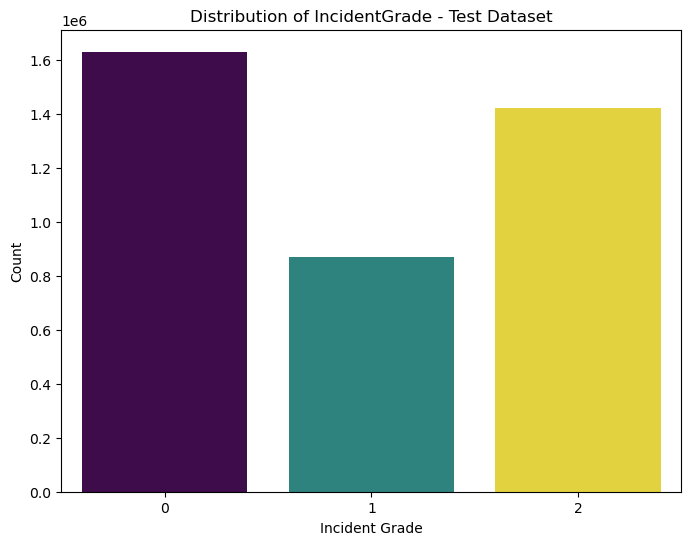

Target variable distribution:
IncidentGrade
0    1630942
2    1422856
1     868897
Name: count, dtype: int64


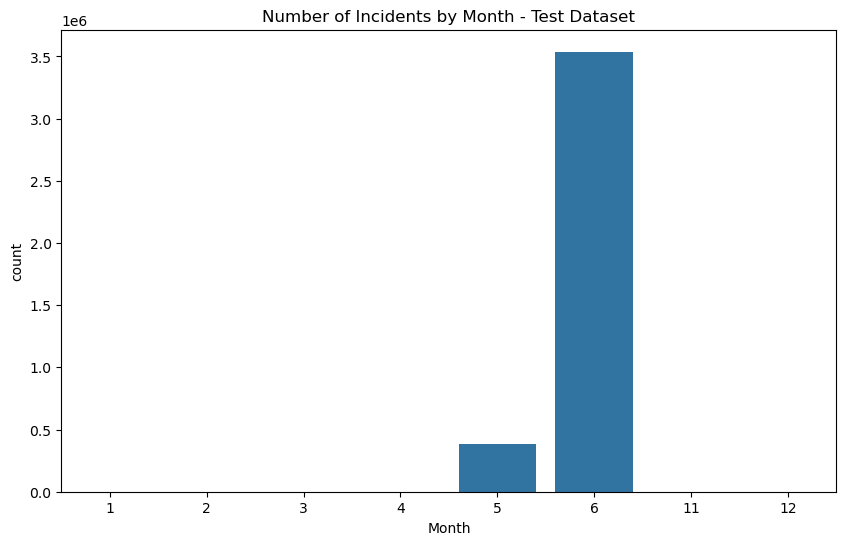

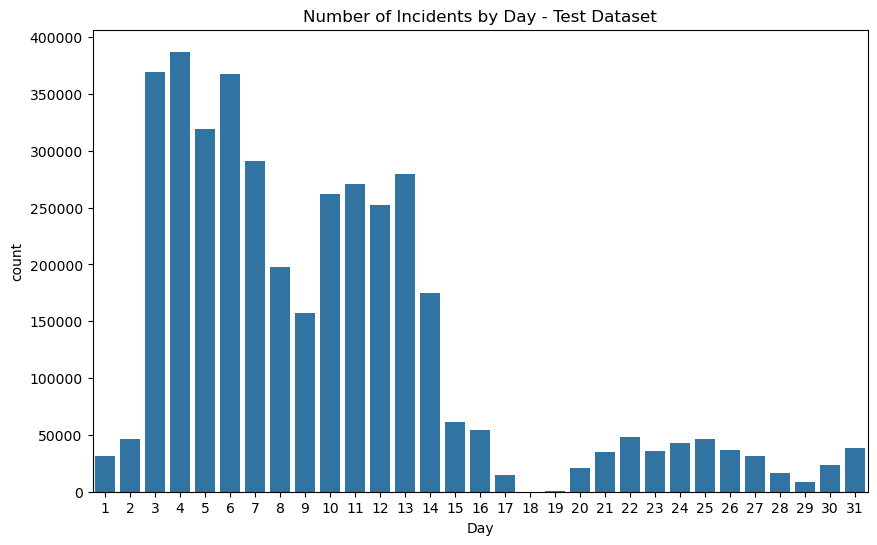

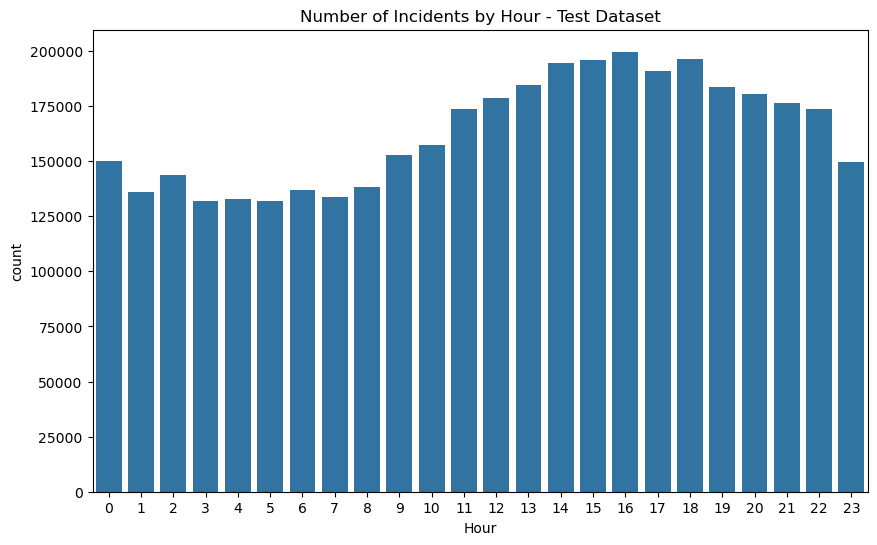

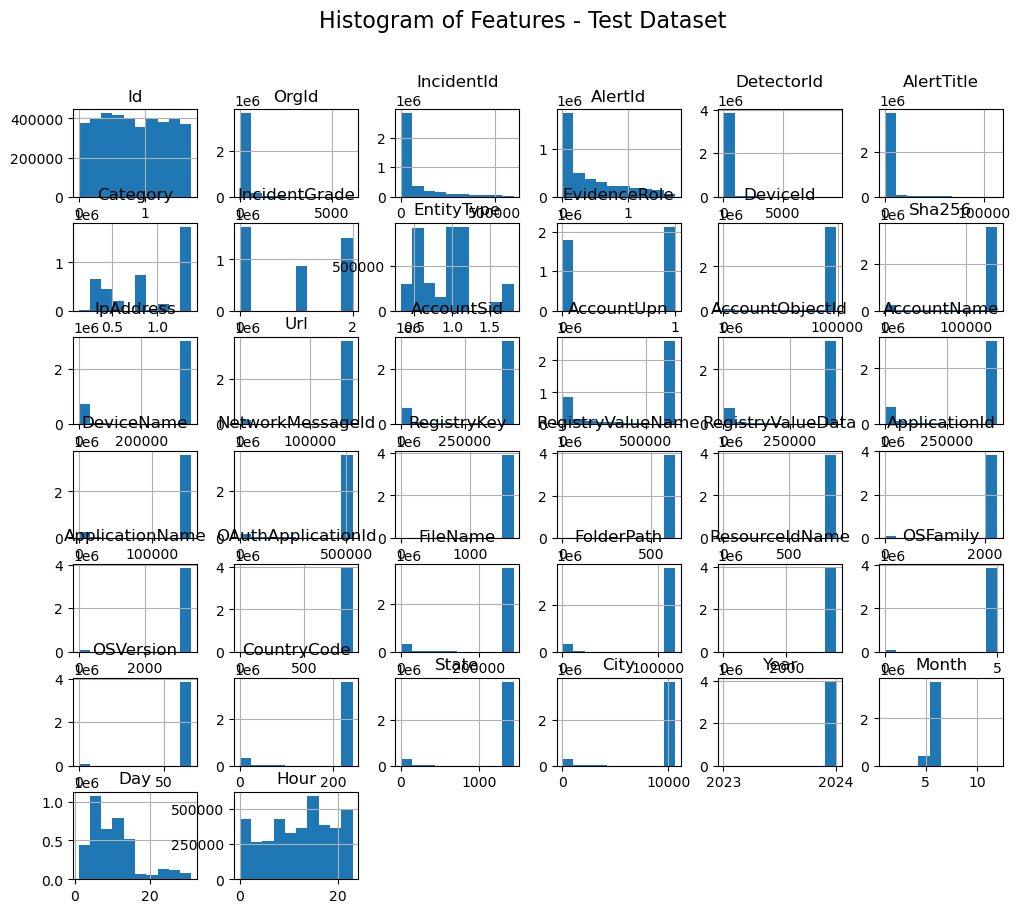


 Plotting Selected Columns Correlation Heatmap...


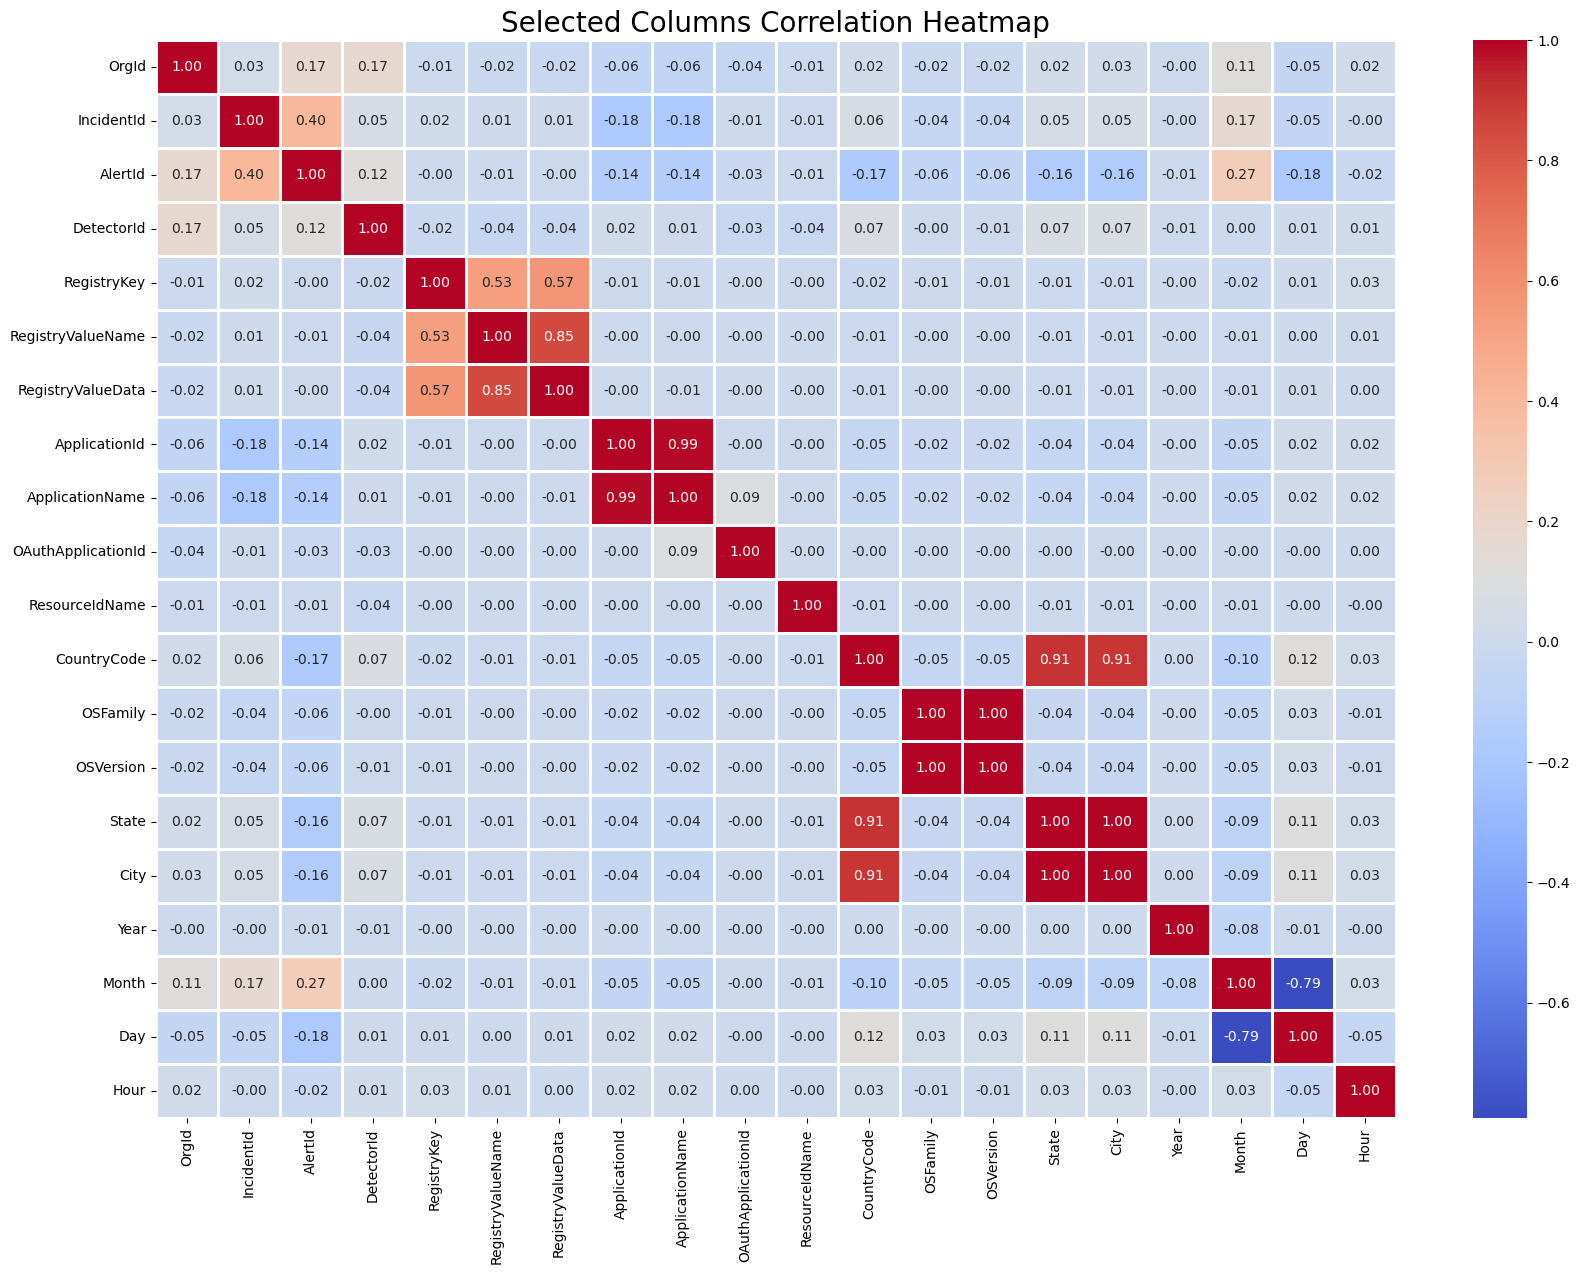

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

def explore_data(data, dataset_name="Dataset", plot_target_distribution=True):
    """
    Function to plot distributions and basic exploration of the dataset.
    
    Parameters:
    - data: DataFrame to explore
    - dataset_name: Name of the dataset (for titles)
    - plot_target_distribution: Whether to plot IncidentGrade distribution
    """
    # 1. Plot Target variable distribution
    if plot_target_distribution and 'IncidentGrade' in data.columns:
        plt.figure(figsize=(8, 6))
        sns.countplot(data=data, x='IncidentGrade', hue='IncidentGrade', palette='viridis', legend=False)
        plt.title(f"Distribution of IncidentGrade - {dataset_name}")
        plt.xlabel("Incident Grade")
        plt.ylabel("Count")
        plt.show()
        
        print("Target variable distribution:")
        print(data['IncidentGrade'].value_counts())
    
    # 2. Incidents by Month
    if 'Month' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Month', data=data)
        plt.title(f'Number of Incidents by Month - {dataset_name}')
        plt.show()

    # 3. Incidents by Day
    if 'Day' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Day', data=data)
        plt.title(f'Number of Incidents by Day - {dataset_name}')
        plt.show()

    # 4. Incidents by Hour
    if 'Hour' in data.columns:
        plt.figure(figsize=(10, 6))
        sns.countplot(x='Hour', data=data)
        plt.title(f'Number of Incidents by Hour - {dataset_name}')
        plt.show()

    # 5. Histogram of all features
    data.hist(figsize=(12,10))
    plt.suptitle(f'Histogram of Features - {dataset_name}', fontsize=16)
    plt.show()

    # 6. Bar Plots for Categorical Features
    categorical_columns = data.select_dtypes(include=['object', 'category']).columns
    for col in categorical_columns:
        plt.figure(figsize=(6, 4))
        data[col].value_counts().plot(kind='bar')
        plt.title(f'Distribution of {col} - {dataset_name}')
        plt.xlabel(col)
        plt.show()

    # 7. Specific Correlation Heatmap (Selected columns)
    print("\n Plotting Selected Columns Correlation Heatmap...")
    correlation_columns = [
        'OrgId','IncidentId','AlertId','DetectorId','RegistryKey', 
        'RegistryValueName', 'RegistryValueData','ApplicationId', 
        'ApplicationName','OAuthApplicationId','ResourceIdName', 
        'CountryCode','OSFamily','OSVersion','State','City',
        'Year','Month','Day','Hour'
    ]
    subset_df = data[correlation_columns].copy()

    plt.figure(figsize=(20, 14))
    subset_corr_matrix = subset_df.corr()
    sns.heatmap(subset_corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.8)
    plt.title('Selected Columns Correlation Heatmap', fontsize=20)
    plt.show()



# Load cleaned data from joblib
test_data = load('cleaned_test_data.joblib')
print("\n Loaded cleaned dataset from 'cleaned_test_data.joblib'")

# Explore the loaded data
explore_data(test_data, dataset_name="Test Dataset")

In [9]:
from sklearn.model_selection import train_test_split

# Define features and target
X = train_data.drop(columns=['IncidentGrade'])  # Features
y = train_data['IncidentGrade']  # Target

# Stratified split to maintain class balance
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}")


Train shape: (7138244, 37), Validation shape: (1784561, 37)


In [10]:
# Full dataset distribution
print("Full data distribution:")
print(y.value_counts(normalize=True))

# Training set distribution
print("\nTraining data distribution:")
print(y_train.value_counts(normalize=True))

# Validation set distribution
print("\nValidation data distribution:")
print(y_val.value_counts(normalize=True))


Full data distribution:
IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64

Training data distribution:
IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64

Validation data distribution:
IncidentGrade
0    0.428991
2    0.351921
1    0.219088
Name: proportion, dtype: float64


In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

def evaluate_model(name, y_true, y_pred):
    print(f"\n========== {name} ==========")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4, zero_division=0))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_true, y_pred))


In [12]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
logreg.fit(X_train_scaled, y_train)
y_pred_logreg = logreg.predict(X_val_scaled)
evaluate_model("Logistic Regression (scaled + balanced)", y_val, y_pred_logreg)



========== Logistic Regression (scaled + balanced) ==========
Accuracy: 0.6042550520828371

Classification Report:
               precision    recall  f1-score   support

           0     0.6636    0.6540    0.6587    765560
           1     0.3838    0.4158    0.3992    390976
           2     0.6845    0.6609    0.6725    628025

    accuracy                         0.6043   1784561
   macro avg     0.5773    0.5769    0.5768   1784561
weighted avg     0.6096    0.6043    0.6067   1784561


Confusion Matrix:
[[500657 157564 107339]
 [144369 162583  84024]
 [109447 103488 415090]]


In [13]:
from sklearn.tree import DecisionTreeClassifier

dtree = DecisionTreeClassifier(
    max_depth=20,
    min_samples_split=4,
    min_samples_leaf=1,
    max_features='log2',
    random_state=42
)
dtree.fit(X_train, y_train)
y_pred_dtree = dtree.predict(X_val)
evaluate_model("Decision Tree (tuned)", y_val, y_pred_dtree)



========== Decision Tree (tuned) ==========
Accuracy: 0.8439862800991392

Classification Report:
               precision    recall  f1-score   support

           0     0.7770    0.9440    0.8524    765560
           1     0.9092    0.7145    0.8002    390976
           2     0.9213    0.8027    0.8579    628025

    accuracy                         0.8440   1784561
   macro avg     0.8692    0.8204    0.8368   1784561
weighted avg     0.8567    0.8440    0.8429   1784561


Confusion Matrix:
[[722671  17309  25580]
 [ 94133 279342  17501]
 [113314  10579 504132]]


In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=100, max_depth=20, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
evaluate_model("Random Forest (basic tuning)", y_val, y_pred_rf)



========== Random Forest (basic tuning) ==========
Accuracy: 0.9209609534221581

Classification Report:
               precision    recall  f1-score   support

           0     0.9001    0.9534    0.9260    765560
           1     0.8754    0.9154    0.8950    390976
           2     0.9839    0.8848    0.9318    628025

    accuracy                         0.9210   1784561
   macro avg     0.9198    0.9179    0.9176   1784561
weighted avg     0.9242    0.9210    0.9212   1784561


Confusion Matrix:
[[729903  29490   6167]
 [ 30156 357916   2904]
 [ 50899  21434 555692]]


In [15]:
from xgboost import XGBClassifier

xgb = XGBClassifier(n_estimators=100, max_depth=3, learning_rate=0.1, verbosity=0, use_label_encoder=False, eval_metric='mlogloss')
xgb.fit(X_train, y_train)
y_pred_xgb = xgb.predict(X_val)
evaluate_model("XGBoost", y_val, y_pred_xgb)



========== XGBoost ==========
Accuracy: 0.7852026352699627

Classification Report:
               precision    recall  f1-score   support

           0     0.6914    0.9665    0.8061    765560
           1     0.8723    0.5319    0.6608    390976
           2     0.9526    0.7219    0.8214    628025

    accuracy                         0.7852   1784561
   macro avg     0.8387    0.7401    0.7628   1784561
weighted avg     0.8229    0.7852    0.7796   1784561


Confusion Matrix:
[[739891  15315  10354]
 [170791 207954  12231]
 [159504  15124 453397]]


In [16]:
import pandas as pd

# Manually filled from your output
report = {
    'Model': [
        'Logistic Regression',
        'Decision Tree',
        'Random Forest',
        'XGBoost'
    ],
    'Accuracy': [
        0.6043,  # Logistic Regression
        0.8440,  # Decision Tree
        0.9210,  # Random Forest
        0.7852   # XGBoost
    ],
    'Macro-F1 Score': [
        0.5768,  # Logistic Regression
        0.8368,  # Decision Tree
        0.9176,  # Random Forest
        0.7628   # XGBoost
    ],
    'Precision': [
        0.5773,  # Logistic Regression
        0.8692,  # Decision Tree
        0.9198,  # Random Forest
        0.8387   # XGBoost
    ],
    'Recall': [
        0.5769,  # Logistic Regression
        0.8204,  # Decision Tree
        0.9179,  # Random Forest
        0.7401   # XGBoost
    ]
}

df = pd.DataFrame(report)

# Show the comparison table
print("\nModel Comparison Table:")
print(df.to_string(index=False))

# Step 2: Determine the best model based on Macro-F1 Score and Accuracy
best_models = df[df['Macro-F1 Score'] == df['Macro-F1 Score'].max()]
if len(best_models) > 1:
    best_model = best_models.loc[best_models['Accuracy'].idxmax()]
else:
    best_model = best_models.iloc[0]

print("\nBest Model Based on Macro-F1 Score (with Accuracy Tiebreaker):")
print(best_model)



Model Comparison Table:
              Model  Accuracy  Macro-F1 Score  Precision  Recall
Logistic Regression    0.6043          0.5768     0.5773  0.5769
      Decision Tree    0.8440          0.8368     0.8692  0.8204
      Random Forest    0.9210          0.9176     0.9198  0.9179
            XGBoost    0.7852          0.7628     0.8387  0.7401

Best Model Based on Macro-F1 Score (with Accuracy Tiebreaker):
Model             Random Forest
Accuracy                  0.921
Macro-F1 Score           0.9176
Precision                0.9198
Recall                   0.9179
Name: 2, dtype: object


In [17]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Train the model
rf_balanced = RandomForestClassifier(
    n_estimators=100,
    max_depth=20,
    class_weight='balanced',  #  This handles class imbalance
    random_state=42
)
rf_balanced.fit(X_train, y_train)

# Predict on validation set
y_pred_bal = rf_balanced.predict(X_val)

# Evaluate
print("Random Forest with class_weight='balanced':")
print("Accuracy:", accuracy_score(y_val, y_pred_bal))
print("Classification Report:\n", classification_report(y_val, y_pred_bal, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred_bal))



Random Forest with class_weight='balanced':
Accuracy: 0.9209609534221581
Classification Report:
               precision    recall  f1-score   support

           0     0.9001    0.9534    0.9260    765560
           1     0.8754    0.9154    0.8950    390976
           2     0.9839    0.8848    0.9318    628025

    accuracy                         0.9210   1784561
   macro avg     0.9198    0.9179    0.9176   1784561
weighted avg     0.9242    0.9210    0.9212   1784561

Confusion Matrix:
 [[729903  29490   6167]
 [ 30156 357916   2904]
 [ 50899  21434 555692]]


In [18]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
import numpy as np

# Step 1: Subsample training data (20%)
X_sub, _, y_sub, _ = train_test_split(
    X_train, y_train,
    train_size=0.2,
    stratify=y_train,
    random_state=42
)

# Step 2: Define smaller hyperparameter space
param_distributions = {
    'n_estimators': [100, 150],
    'max_depth': [15, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True]
}

# Step 3: Initialize Random Forest
rf = RandomForestClassifier(
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

# Step 4: Setup RandomizedSearchCV
random_search_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_distributions,
    n_iter=10,              # Reduced from 20
    scoring='f1_macro',
    cv=2,                   # Faster cross-validation
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Step 5: Run tuning on the subsample
random_search_rf.fit(X_sub, y_sub)

# Step 6: Get best model & evaluate on full validation set
best_rf = random_search_rf.best_estimator_

print("Best Parameters:\n", random_search_rf.best_params_)

# Predict on actual validation set
y_val_pred_rf = best_rf.predict(X_val)
print("\nValidation Set Evaluation:")
print(classification_report(y_val, y_val_pred_rf, target_names=['Class 0', 'Class 1', 'Class 2']))


Fitting 2 folds for each of 10 candidates, totalling 20 fits
Best Parameters:
 {'n_estimators': 150, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 20, 'bootstrap': True}

Validation Set Evaluation:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.92    765560
     Class 1       0.87      0.91      0.89    390976
     Class 2       0.98      0.88      0.93    628025

    accuracy                           0.92   1784561
   macro avg       0.92      0.91      0.91   1784561
weighted avg       0.92      0.92      0.92   1784561



In [19]:
import joblib

# Step 1: Extract best parameters from randomized search
best_params = random_search_rf.best_params_

# Step 2: Train final model on full X_train
final_rf = RandomForestClassifier(
    **best_params,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1
)

final_rf.fit(X_train, y_train)

# Step 3: Evaluate on validation set
y_val_pred_final = final_rf.predict(X_val)

print("\nFinal Evaluation on Validation Set:")
print(classification_report(y_val, y_val_pred_final, target_names=['Class 0', 'Class 1', 'Class 2']))

# Step 4: Save the final model
joblib.dump(final_rf, 'final_random_forest_model.pkl')
print("\nModel saved as 'final_random_forest_model.pkl'")



Final Evaluation on Validation Set:
              precision    recall  f1-score   support

     Class 0       0.90      0.95      0.93    765560
     Class 1       0.88      0.92      0.89    390976
     Class 2       0.98      0.88      0.93    628025

    accuracy                           0.92   1784561
   macro avg       0.92      0.92      0.92   1784561
weighted avg       0.92      0.92      0.92   1784561


Model saved as 'final_random_forest_model.pkl'


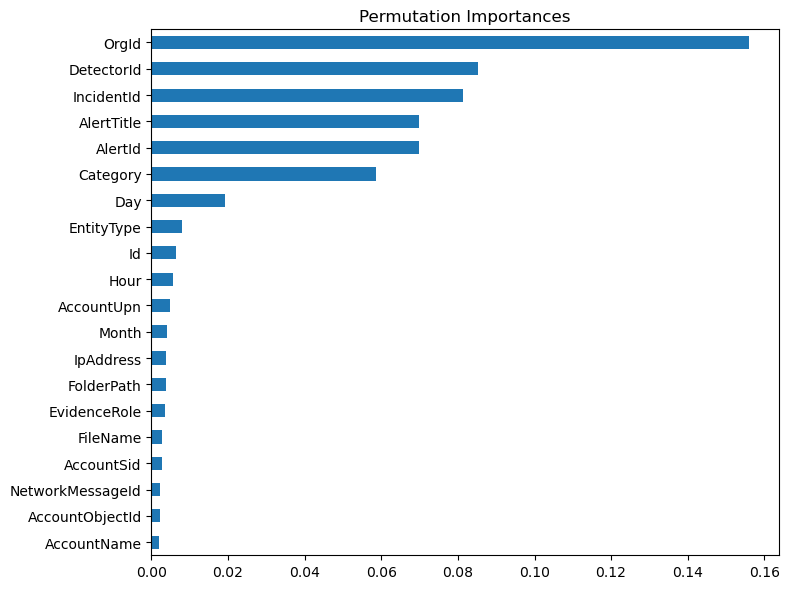

In [20]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance

# Step 1: Load the saved model
final_rf = joblib.load('final_random_forest_model.pkl')

# Step 2: Compute permutation importance
result = permutation_importance(
    final_rf, X_val, y_val,
    n_repeats=3,
    random_state=42,
    scoring='f1_macro',
    n_jobs=-1
)

# Step 3: Prepare and plot feature importance
perm_importances = pd.Series(result.importances_mean, index=X_val.columns)
perm_importances = perm_importances.sort_values(ascending=False)

# Step 4: Plot top 20 features
perm_importances.head(20).plot(kind='barh', title="Permutation Importances", figsize=(8, 6))
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [23]:
import joblib
from sklearn.metrics import classification_report, confusion_matrix

# Load your saved final model
best_rf = joblib.load("final_random_forest_model.pkl")

# Load the encoded test dataset (make sure this is the correctly preprocessed test set)
test_data = joblib.load('cleaned_test_data.joblib', mmap_mode='r')

# Split into features and target
X_test = test_data.drop('IncidentGrade', axis=1)
y_test = test_data['IncidentGrade']

# Predict on test data
y_test_pred = best_rf.predict(X_test)

# Print classification report
print("\nClassification Report on Test Data:")
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Print macro average scores
print("\nMacro-F1 Score: {:.2f}".format(report['macro avg']['f1-score']))
print("Macro Precision: {:.2f}".format(report['macro avg']['precision']))
print("Macro Recall: {:.2f}".format(report['macro avg']['recall']))

# Print confusion matrix
print("\nConfusion Matrix on Test Data:")
print(confusion_matrix(y_test, y_test_pred))


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- Usage_Public
